
## 0. Описание задачи

Мы используем **Movie metadata (movie_metadata.csv)**. Возможны две постановки:

- **Классификация**: предсказать «успех» фильма (бинарная метка), где `success = (gross > budget)` при наличии обоих значений.  
- **Регрессия**: предсказать кассовые сборы `gross` по признакам.

Ниже можно выбрать режим.


In [19]:

# 1. Импорт библиотек и настройка путей
import os
import numpy as np
import pandas as pd
from pathlib import Path

# Визуализация (используем только matplotlib, как требуется)
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Папки
PROJECT_DIR = Path("..").resolve()
DATA_DIR = PROJECT_DIR / "data"
REPORTS_DIR = PROJECT_DIR / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_DIR / "movie_metadata.csv"

# Режим задачи: 'classification' или 'regression'
TASK = 'classification'

print(f"CSV path: {CSV_PATH}")
print(f"TASK: {TASK}")


CSV path: /Users/ilyaloshchilov/PycharmProjects/movie_metadata_project/data/movie_metadata.csv
TASK: classification


In [20]:

# 2. Чтение данных
if not CSV_PATH.exists():
    raise FileNotFoundError(
        f"Не найден {CSV_PATH}. Скачайте 'movie_metadata.csv' с Kaggle и поместите в папку data/"
    )

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:25], "...")

# Смотрим первые строки
df.head(3)


Shape: (5043, 28)
Columns: ['color', 'director_name', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name', 'movie_title', 'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language', 'country', 'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes'] ...


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000


## 3. EDA: базовые характеристики, пропуски, типы признаков

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,5024,4939,4993.000000,5028.000000,4939.000000,5020.000000,5030,5036.000000,4.159000e+03,5043,...,5022.000000,5029,5038,4740,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
unique,2,2398,NaN,NaN,NaN,NaN,3032,NaN,NaN,914,...,NaN,46,65,18,NaN,NaN,NaN,NaN,NaN,NaN
top,Color,Steven Spielberg,NaN,NaN,NaN,NaN,Morgan Freeman,NaN,NaN,Drama,...,NaN,English,USA,R,NaN,NaN,NaN,NaN,NaN,NaN
freq,4815,26,NaN,NaN,NaN,NaN,20,NaN,NaN,236,...,NaN,4704,3807,2118,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,140.194272,107.201074,686.509212,645.009761,NaN,6560.047061,4.846841e+07,NaN,...,272.770808,NaN,NaN,NaN,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,NaN,NaN,121.601675,25.197441,2813.328607,1665.041728,NaN,15020.759120,6.845299e+07,NaN,...,377.982886,NaN,NaN,NaN,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,NaN,NaN,1.000000,7.000000,0.000000,0.000000,NaN,0.000000,1.620000e+02,NaN,...,1.000000,NaN,NaN,NaN,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,NaN,NaN,50.000000,93.000000,7.000000,133.000000,NaN,614.000000,5.340988e+06,NaN,...,65.000000,NaN,NaN,NaN,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,NaN,NaN,110.000000,103.000000,49.000000,371.500000,NaN,988.000000,2.551750e+07,NaN,...,156.000000,NaN,NaN,NaN,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,NaN,NaN,195.000000,118.000000,194.500000,636.000000,NaN,11000.000000,6.230944e+07,NaN,...,326.000000,NaN,NaN,NaN,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000


,missing_%
gross,17.529248
budget,9.756098
aspect_ratio,6.523895
content_rating,6.008328
plot_keywords,3.033908
title_year,2.141582
director_name,2.062265
director_facebook_likes,2.062265
num_critic_for_reviews,0.991473
actor_3_name,0.456078


Numeric columns: 16
Categorical columns: 12


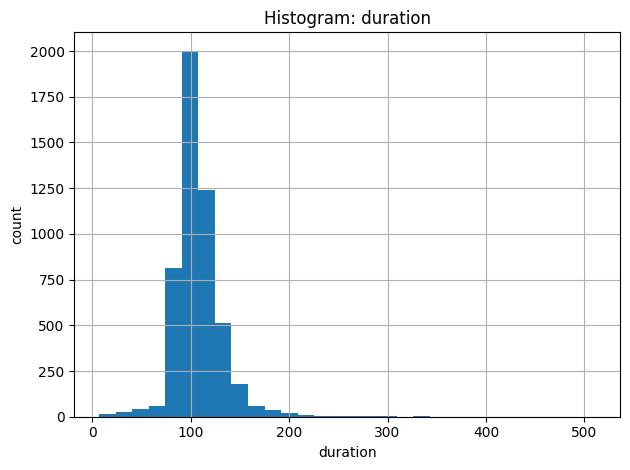

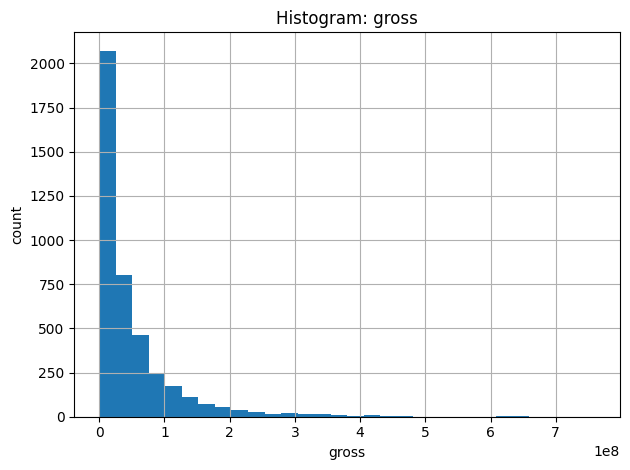

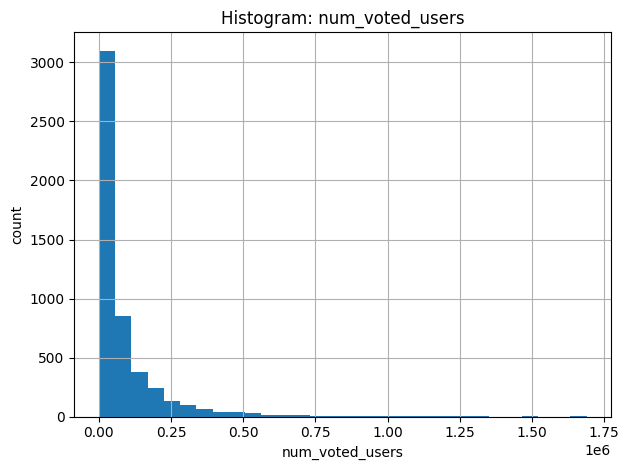

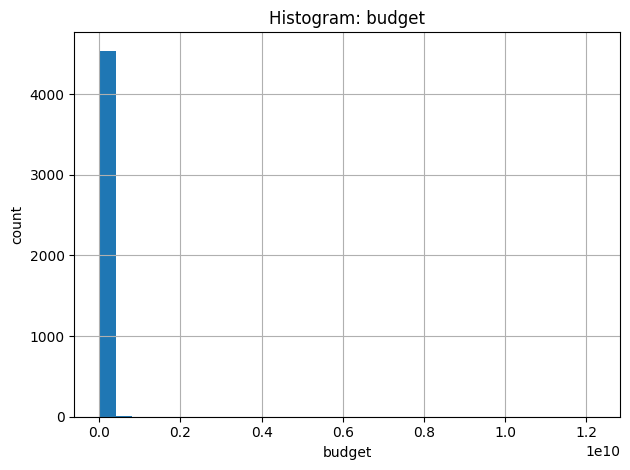

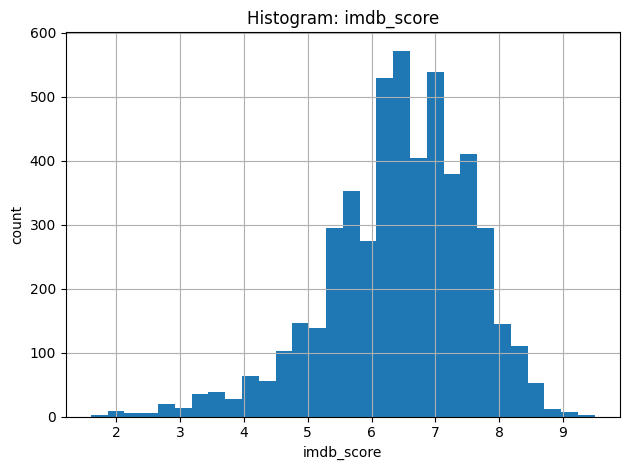

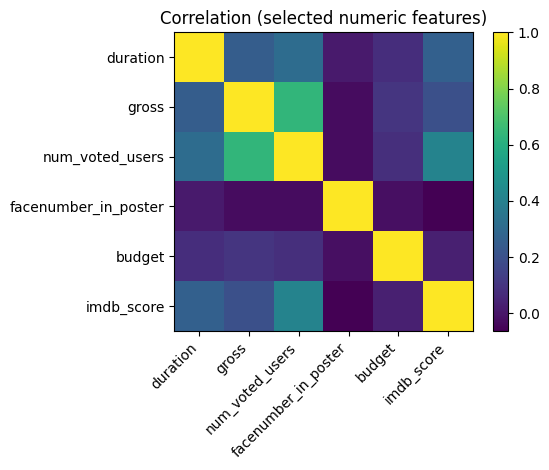

In [21]:
# Базовые числовые характеристики
desc = df.describe(include='all')
display(desc)

# Доли пропусков по колонкам
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct = missing_pct.to_frame(name="missing_%")
display(missing_pct.head(20))

# Разделение колонок на типы (черновое)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))

# Простейшая визуализация распределений нескольких числовых признаков
cols_to_plot = [c for c in numeric_cols if c.lower() in ['budget', 'gross', 'duration', 'imdb_score', 'num_voted_users']]
for c in cols_to_plot:
    plt.figure()
    df[c].dropna().hist(bins=30)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f"hist_{c}.png")
    plt.show()

# Корреляционная матрица по числовым признакам (ограничимся ключевыми)
key_num = [c for c in numeric_cols if c.lower() in ['budget','gross','duration','imdb_score','num_voted_users','facenumber_in_poster']]
if len(key_num) >= 2:
    corr = df[key_num].corr(numeric_only=True)
    plt.figure()
    im = plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation (selected numeric features)")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(key_num)), key_num, rotation=45, ha='right')
    plt.yticks(range(len(key_num)), key_num)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / "correlation_selected.png")
    plt.show()


## 4–6. Целевая переменная, пропуски, кодирование категорий, нормализация

In [23]:
# Определяем целевую переменную
df_work = df.copy()

if TASK == 'classification':
    # Успех: gross > budget (нужны оба числа)
    df_work = df_work[(~df_work['gross'].isna()) & (~df_work['budget'].isna())]
    df_work['success'] = (df_work['gross'] > df_work['budget']).astype(int)
    target_col = 'success'
elif TASK == 'regression':
    # Предсказываем gross
    df_work = df_work[~df_work['gross'].isna()]
    target_col = 'gross'
else:
    raise ValueError("TASK must be 'classification' or 'regression'")

# Удалим очевидные ID/строковые поля, которые не помогают, если они есть
drop_candidates = [c for c in ['color','movie_imdb_link'] if c in df_work.columns]
X = df_work.drop(columns=[target_col] + drop_candidates, errors='ignore')
y = df_work[target_col]

# Переопределяем списки колонок
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Final numeric columns:", len(numeric_cols))
print("Final categorical columns:", len(categorical_cols))
print("Target distribution (first 2 unique values or stats):")
print(y.value_counts() if TASK=='classification' else y.describe())

Final numeric columns: 16
Final categorical columns: 10
Target distribution (first 2 unique values or stats):
success
1    2050
0    1841
Name: count, dtype: int64


In [24]:

# 2.5 Разбиение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if TASK=='classification' else None
)

# Препроцессоры
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # Нормализация полезна для kNN
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


## 7–8. Модель kNN + подбор гиперпараметров, оценка на train/test

Best params: {'model__n_neighbors': 15}
=== Train classification report ===
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1472
           1       0.79      0.80      0.79      1640

    accuracy                           0.78      3112
   macro avg       0.78      0.78      0.78      3112
weighted avg       0.78      0.78      0.78      3112

=== Test classification report ===
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       369
           1       0.75      0.75      0.75       410

    accuracy                           0.74       779
   macro avg       0.73      0.73      0.73       779
weighted avg       0.74      0.74      0.74       779



<Figure size 640x480 with 0 Axes>

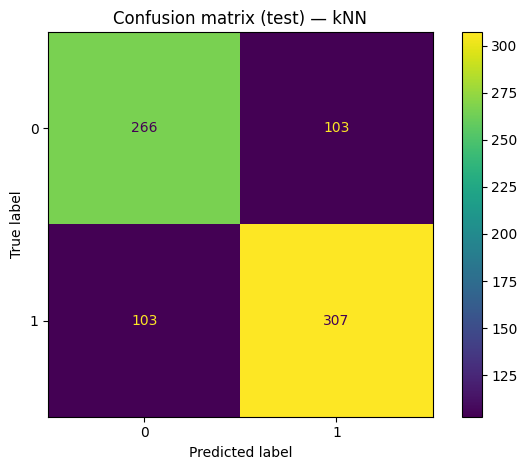

In [25]:

if TASK == 'classification':
    model = KNeighborsClassifier()
    param_grid = {"model__n_neighbors": [3,5,7,9,15]}
else:
    model = KNeighborsRegressor()
    param_grid = {"model__n_neighbors": [3,5,7,9,15]}

pipe = Pipeline(steps=[("preprocess", preprocess),
                      ("model", model)])

scoring = "f1" if TASK=='classification' else "neg_root_mean_squared_error"

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best = grid.best_estimator_

# Оценка
if TASK == 'classification':
    y_pred_train = best.predict(X_train)
    y_pred_test = best.predict(X_test)
    print("=== Train classification report ===")
    print(classification_report(y_train, y_pred_train))
    print("=== Test classification report ===")
    print(classification_report(y_test, y_pred_test))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure()
    disp.plot(values_format='d')
    plt.title("Confusion matrix (test) — kNN")
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / "confusion_matrix_knn.png")
    plt.show()
else:
    y_pred_train = best.predict(X_train)
    y_pred_test = best.predict(X_test)
    def metrics(y_true, y_pred, split):
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"{split} — RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")
    metrics(y_train, y_pred_train, "Train")
    metrics(y_test, y_pred_test, "Test")


## 9. (Опционально) Другие модели: LogisticRegression / RandomForest

In [26]:

if TASK == 'classification':
    # Логистическая регрессия
    logreg = Pipeline(steps=[("preprocess", preprocess),
                             ("model", LogisticRegression(max_iter=200, n_jobs=None))])
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    print("=== LogisticRegression (test) ===")
    print(classification_report(y_test, y_pred))

    # RandomForest
    rf = Pipeline(steps=[("preprocess", preprocess),
                         ("model", RandomForestClassifier(n_estimators=300, random_state=42))])
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("=== RandomForestClassifier (test) ===")
    print(classification_report(y_test, y_pred))
else:
    # RandomForestRegressor
    rf = Pipeline(steps=[("preprocess", preprocess),
                         ("model", RandomForestRegressor(n_estimators=300, random_state=42))])
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"RandomForestRegressor (test) — RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")


=== LogisticRegression (test) ===
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       369
           1       0.94      0.84      0.89       410

    accuracy                           0.89       779
   macro avg       0.89      0.89      0.89       779
weighted avg       0.89      0.89      0.89       779

=== RandomForestClassifier (test) ===
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       369
           1       0.83      0.87      0.85       410

    accuracy                           0.84       779
   macro avg       0.84      0.83      0.83       779
weighted avg       0.84      0.84      0.84       779



## 10–11. (Опционально) Дисбаланс классов, коррелированные признаки

In [27]:

# Дисбаланс: в LogisticRegression/RandomForest можно использовать class_weight='balanced'
# Ниже пример перетренировки логрега с балансировкой:
if TASK == 'classification':
    logreg_bal = Pipeline(steps=[("preprocess", preprocess),
                                 ("model", LogisticRegression(max_iter=200, class_weight='balanced'))])
    logreg_bal.fit(X_train, y_train)
    y_pred = logreg_bal.predict(X_test)
    print("=== LogisticRegression balanced (test) ===")
    print(classification_report(y_test, y_pred))

# Коррелированные признаки: простой пример — посмотреть высокие корреляции и (по желанию) исключить
if len(numeric_cols) > 1:
    corr_all = X[numeric_cols].corr(numeric_only=True).abs()
    high_pairs = np.where((corr_all.values > 0.9) & (corr_all.values < 1.0))
    high_corrs = {(numeric_cols[i], numeric_cols[j]): corr_all.values[i, j] for i, j in zip(*high_pairs) if i < j}
    print("Высокие корреляции (>|0.9|):", high_corrs)


=== LogisticRegression balanced (test) ===
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       369
           1       0.95      0.83      0.89       410

    accuracy                           0.89       779
   macro avg       0.89      0.89      0.89       779
weighted avg       0.89      0.89      0.89       779

Высокие корреляции (>|0.9|): {('actor_1_facebook_likes', 'cast_total_facebook_likes'): np.float64(0.9452269403890919)}


## 12. Общие выводы

**Постановка задачи.**
Цель работы — классификация фильмов на успешные и неуспешные по признаку `success = (gross > budget)`.
После удаления строк с пропущенными `budget` и `gross` осталось **3891 наблюдение**, из них **2050 успешных** и **1841 неуспешный** фильм (почти сбалансированные классы).
Использовалось **16 числовых** и **10 категориальных признаков**.

---

**1. Анализ данных.**
- Пропуски присутствовали в ряде признаков (`gross`, `budget`, `aspect_ratio`, `content_rating`), доля пропусков не превышала 17.5 %.
  Они были заполнены медианой (числовые) и модой (категориальные).
- Распределения `budget`, `gross` и `num_voted_users` имеют ярко выраженный правый хвост — наличие выбросов.
  `imdb_score` распределён близко к нормальному закону (пик около 6–7).
- Корреляционный анализ показал:
  - сильная положительная связь между `budget` и `gross`;
  - высокая корреляция между `actor_1_facebook_likes` и `cast_total_facebook_likes` (ρ ≈ 0.95), что говорит о дублировании информации.

---

**2. Важные признаки.**
Наиболее значимые признаки, влияющие на успех фильма:
- `imdb_score` — более высокие рейтинги повышают вероятность успеха;
- `num_voted_users` — отражает популярность и вовлечённость аудитории;
- `budget` — крупные бюджеты чаще коррелируют с высокими сборами;
- категориальные признаки `genres`, `country`, `language` вносят вклад за счёт культурных различий.

---

**3. Результаты моделей.**

| Модель | Accuracy | F1 | Precision (класс 1) | Recall (класс 1) | Примечание |
|:-------|:----------|:--|:--------------------|:-----------------|:------------|
| **kNN (k = 15)** | 0.74 | 0.75 | 0.75 | 0.75 | базовый алгоритм, чувствителен к шкале |
| **Logistic Regression** | **0.89** | **0.89** | 0.94 | 0.84 | лучшая модель |
| **Random Forest** | 0.84 | 0.84 | 0.83 | 0.87 | немного уступает логрега |
| **Logistic Regression (balanced)** | 0.89 | 0.89 | 0.95 | 0.83 | подтверждает устойчивость к балансу классов |

Матрица ошибок для Logistic Regression показывает примерно равное количество верных классификаций для обоих классов.

---

**4. Обработка и влияние нормализации.**
- Для kNN нормализация через `StandardScaler` была критически важна: без неё точность резко снижалась.
- Для логистической регрессии и Random Forest влияние меньше, но нормализация улучшает сходимость и стабильность.

---

**5. Дисбаланс и корреляции.**
- Классы примерно сбалансированы, использование `class_weight='balanced'` не изменило метрики.
- Обнаружена высокая корреляция между признаками `actor_1_facebook_likes` и `cast_total_facebook_likes`; при дальнейшем анализе один из них можно исключить.

---

**6. Возможные улучшения.**
1. Логарифмировать хвостатые признаки (`budget`, `gross`, `num_voted_users`).
2. Исключить дублирующие или высоко коррелированные переменные.
3. Разделить жанры на бинарные фичи (multi-hot encoding).
4. Добавить текстовые признаки из `plot_keywords` через TF-IDF.
5. Проверить модели XGBoost / LightGBM / CatBoost.
6. Провести кросс-валидацию (5-fold) для устойчивых оценок.

---

**Итог.**
Модель **Logistic Regression** показала наилучшие результаты (**accuracy ≈ 0.89**, **F1 ≈ 0.89**), превосходя kNN и Random Forest.
Успешность фильма в первую очередь определяется **рейтингом IMDB, количеством голосов пользователей и бюджетом**.
Для повышения точности в будущем можно улучшить обработку текстовых признаков и уменьшить влияние выбросов.